In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import pandas as pd
import pystan
import seaborn as sns
from io import StringIO

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

In [3]:
def plot_fitted_line(fit, x, y, xerr=None, yerr=None):
    xmin = np.min(x)
    xmax = np.max(x)
    
    xmin, xmax = (xmin - 0.1*(xmax-xmin)), (xmax + 0.1*(xmax-xmin))
    
    xs = linspace(xmin, xmax, 100)
    ys = []
    for m, b in zip(fit.posterior.m.values.flatten(), fit.posterior.b.values.flatten()):
        ys.append(m*xs + b)
    ys = array(ys)
    
    l, = plot(xs, median(ys, axis=0))
    fill_between(xs, percentile(ys, 84, axis=0), percentile(ys, 16, axis=0), color=l.get_color(), alpha=0.25)
    fill_between(xs, percentile(ys, 97.5, axis=0), percentile(ys, 2.5, axis=0), color=l.get_color(), alpha=0.25)
    
    # Plot the data
    errorbar(x, y, xerr=xerr, yerr=yerr, color='k', fmt='.')
    
def plot_inferred_ys_noscatter(fit, x):
    ys = []
    for m, b in zip(fit.posterior.m.values.flatten(), fit.posterior.b.values.flatten()):
        ys.append(m*x + b)
    ys = array(ys)
    
    errorbar(x, mean(ys, axis=0), yerr=std(ys, axis=0), fmt='.')

Here is the Hogg, Bovy & Lang (2010) data set (normally so good at this, they neglected to publish the data separately, so I had to scrape the PDF):

In [4]:
hogg_data = pd.read_csv(StringIO("""ID	x	y	sigma_x	sigma_y	rho_xy
1	201	592	61	9	-0.84
2	244	401	25	4	0.31
3	47	583	38	11	0.64
4	287	402	15	7	-0.27
5	203	495	21	5	-0.33
6	58	173	15	9	0.67
7	210	479	27	4	-0.02
8	202	504	14	4	-0.05
9	198	510	30	11	-0.84
10	158	416	16	7	-0.69
11	165	393	14	5	0.30
12	201	442	25	5	-0.46
13	157	317	52	5	-0.03
14	131	311	16	6	0.50
15	166	400	34	6	0.73
16	160	337	31	5	-0.52
17	186	423	42	9	0.90
18	125	334	26	8	0.40
19	218	533	16	6	-0.78
20	146	344	22	5	-0.56
"""), sep='\t')
hogg_data

,ID,x,y,sigma_x,sigma_y,rho_xy
0,1,201,592,61,9,-0.84
1,2,244,401,25,4,0.31
2,3,47,583,38,11,0.64
3,4,287,402,15,7,-0.27
4,5,203,495,21,5,-0.33
5,6,58,173,15,9,0.67
6,7,210,479,27,4,-0.02
7,8,202,504,14,4,-0.05
8,9,198,510,30,11,-0.84
9,10,158,416,16,7,-0.69


<ErrorbarContainer object of 3 artists>

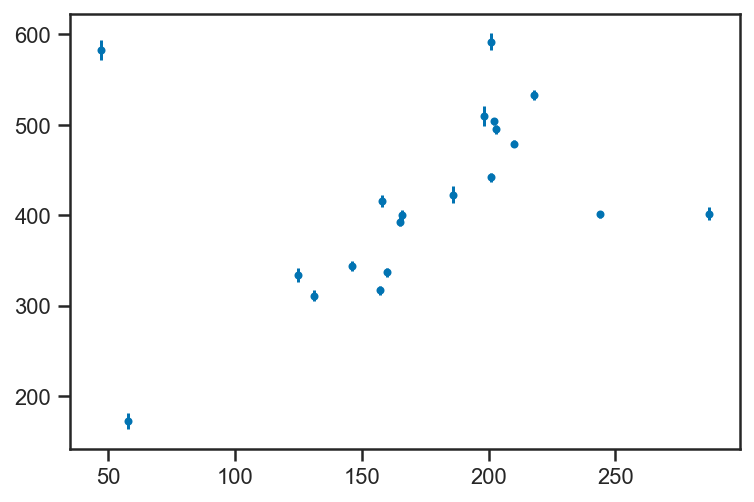

In [5]:
errorbar(hogg_data['x'], hogg_data['y'], yerr=hogg_data['sigma_y'], fmt='.')

In [6]:
igood = 4

<ErrorbarContainer object of 3 artists>

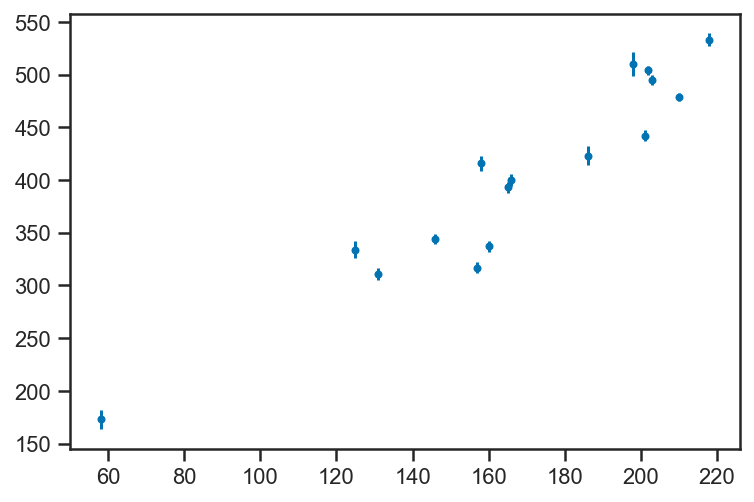

In [7]:
errorbar(hogg_data['x'][igood:], hogg_data['y'][igood:], yerr=hogg_data['sigma_y'][igood:], fmt='.')

In [8]:
model = pystan.StanModel(file='../stan/linear.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d242dc879ec246da3d07c30fb04b270 NOW.
/Users/wfarr/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmptnxksxy2/stanfit4anon_model_3d242dc879ec246da3d07c30fb04b270_635174904276811115.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [9]:
data = {
    'nobs': len(hogg_data['x'])-igood,
    'xobs': hogg_data['x'][igood:],
    'yobs': hogg_data['y'][igood:],
    'sigma_y': hogg_data['sigma_y'][igood:]
}

In [10]:
fit = model.sampling(data=data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1177e8f28>,
      dtype=object)

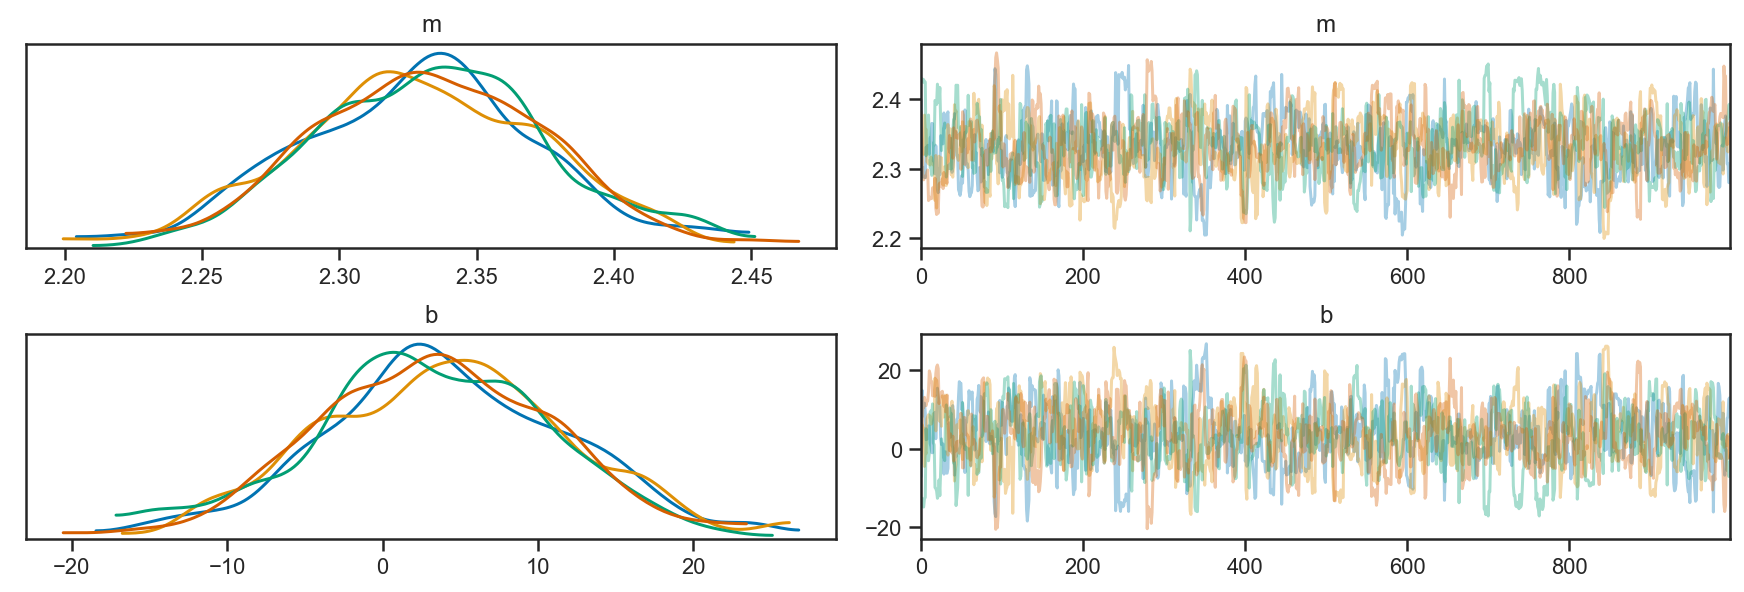

In [13]:
az.plot_trace(fit, var_names=['m', 'b'])

In [14]:
az.effective_sample_size(fit, var_names=['m', 'b'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    m        float64 490.3
    b        float64 461.1

In [16]:
fit = az.convert_to_inference_data(fit)

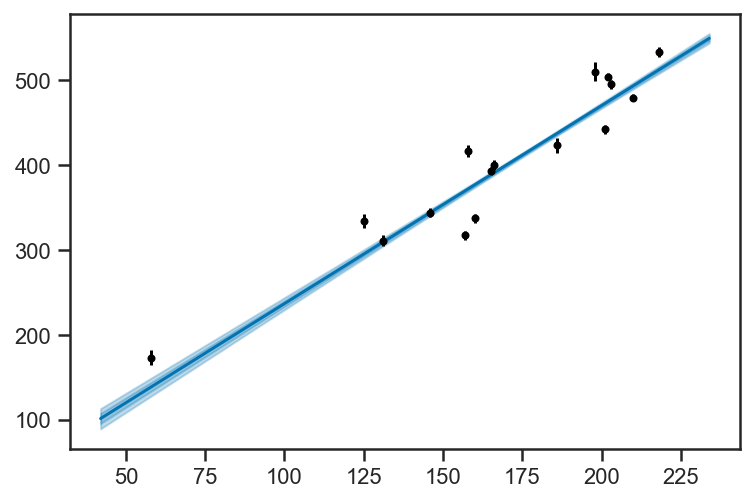

In [21]:
plot_fitted_line(fit, hogg_data['x'][igood:], hogg_data['y'][igood:], yerr=hogg_data['sigma_y'][igood:])

In [22]:
model_scatter = pystan.StanModel(file='../stan/linear_scatter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70b05456641533d724ce5ef5460c1644 NOW.
/Users/wfarr/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpjumvucwj/stanfit4anon_model_70b05456641533d724ce5ef5460c1644_6919991353757140430.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [23]:
fit_scatter = model_scatter.sampling(data=data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bc4ba20>,
      dtype=object)

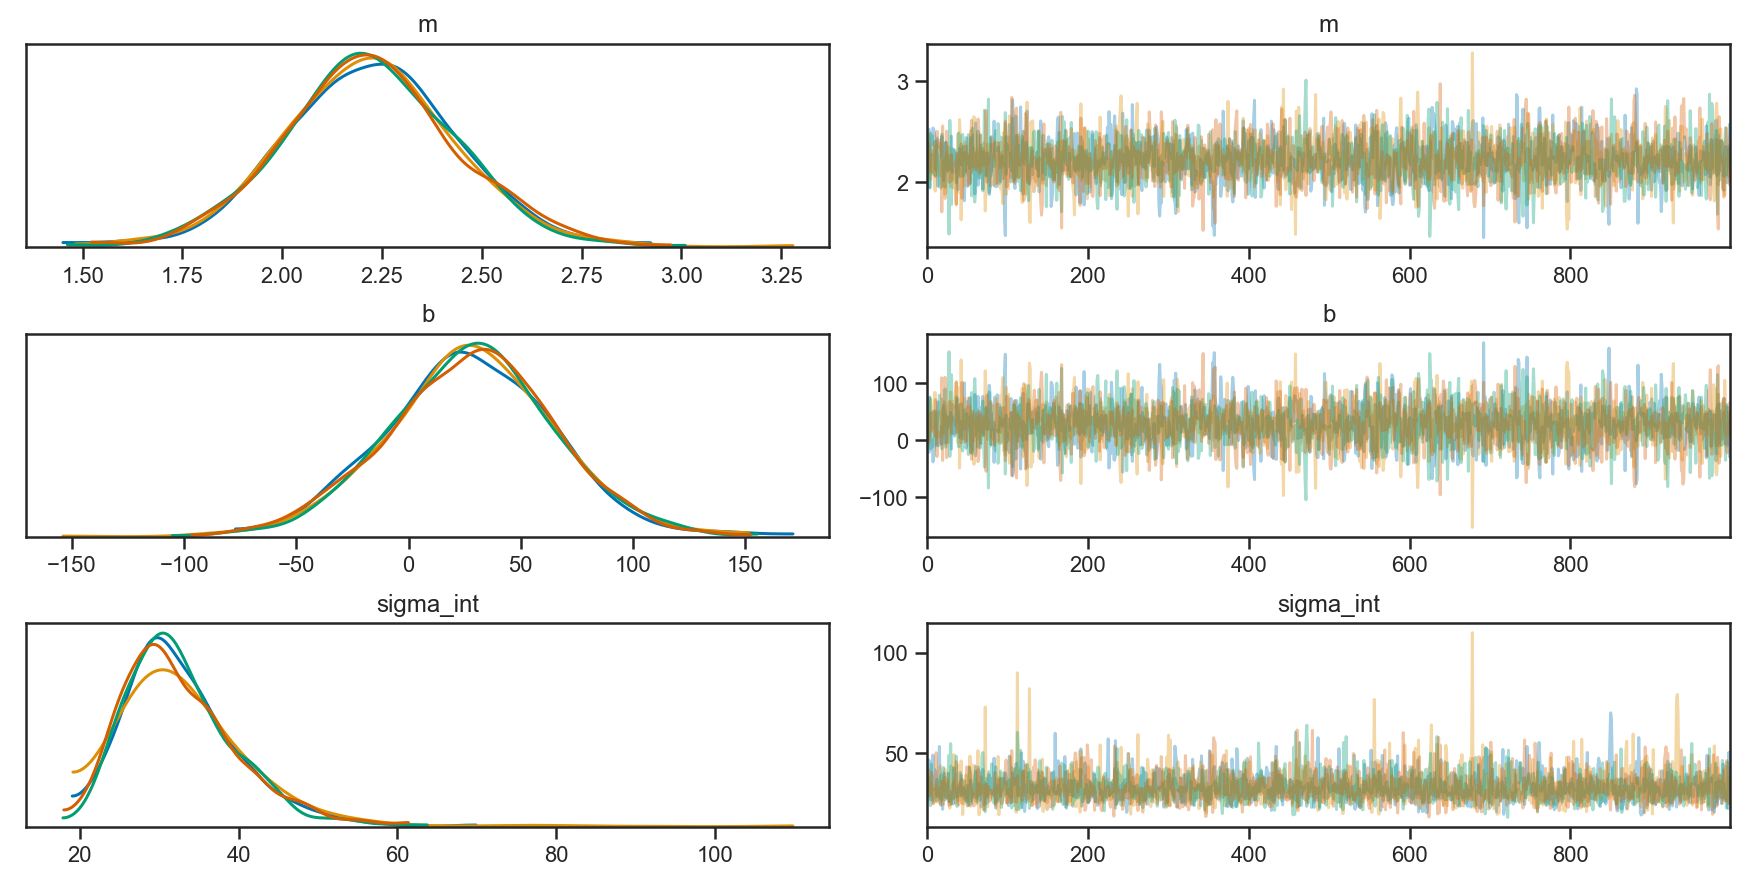

In [24]:
az.plot_trace(fit_scatter, var_names=['m', 'b', 'sigma_int'])

In [25]:
fit_scatter = az.convert_to_inference_data(fit_scatter)

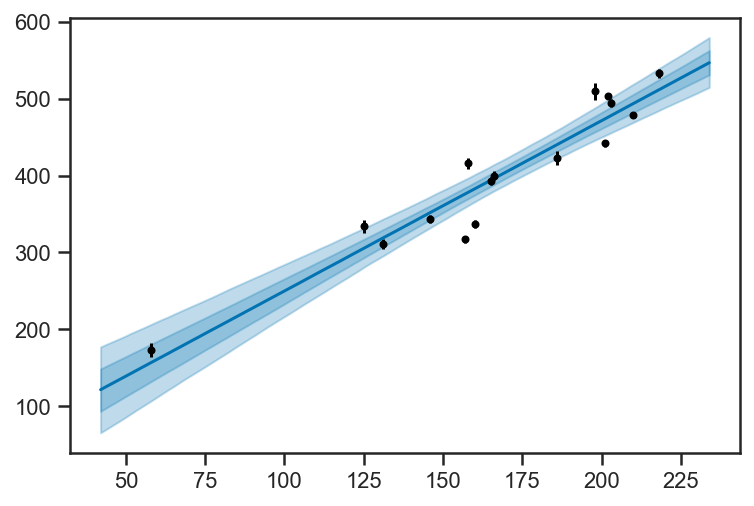

In [27]:
plot_fitted_line(fit_scatter, hogg_data['x'][igood:], hogg_data['y'][igood:], yerr=hogg_data['sigma_y'][igood:])

## Problem 1

Incorporate the uncertainty in the measurement of $x$ from [Hogg, Bovy & Lang (2010)](https://arxiv.org/pdf/1008.4686.pdf) into your model.  You will need to introduce a variable $x_\mathrm{true}$ (just like our $y_\mathrm{true}$) and include an observational likelihood for its values.  Make plots of your fits similar to those we have produced.  Is your model reasonable?  (Remember to fit data points 5 to 20, as the first four points are outliers!)

Can you write a version of this model that uses a mixture model to fit out the outliers, as we did above?

Can you extend your model to account for either intrinsic scatter or inaccuracy in the measurement uncertainties reported in both dimensions, as we did before?  Could you account for both effects in this data set?

### Partial Solution: Uncertainties in $x$

We will attack the case where there are additional uncertainties in the $x$ dimension.

In [28]:
model_xerr = pystan.StanModel(file='../stan/linear_xerr.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dab70b2016d599d0eb702cc982fa34fa NOW.
/Users/wfarr/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp2d3x5u88/stanfit4anon_model_dab70b2016d599d0eb702cc982fa34fa_5606656702065617647.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [31]:
data_xerr = data.copy()
data_xerr['sigma_x'] = hogg_data['sigma_x'][igood:]

In [32]:
fit_xerr = model_xerr.sampling(data=data_xerr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ef96a58>,
      dtype=object)

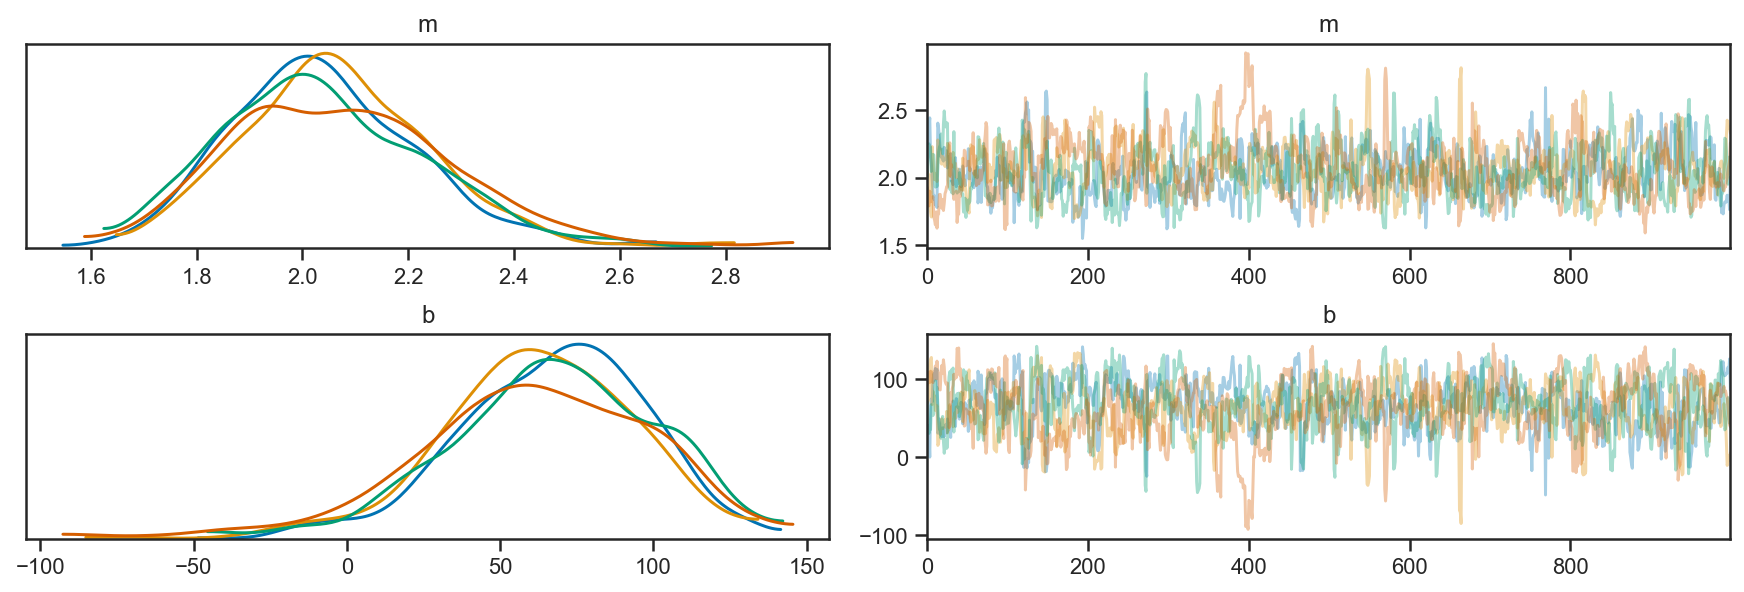

In [34]:
az.plot_trace(fit_xerr, var_names=['m', 'b'])

In [39]:
fit_xerr = az.convert_to_inference_data(fit_xerr)

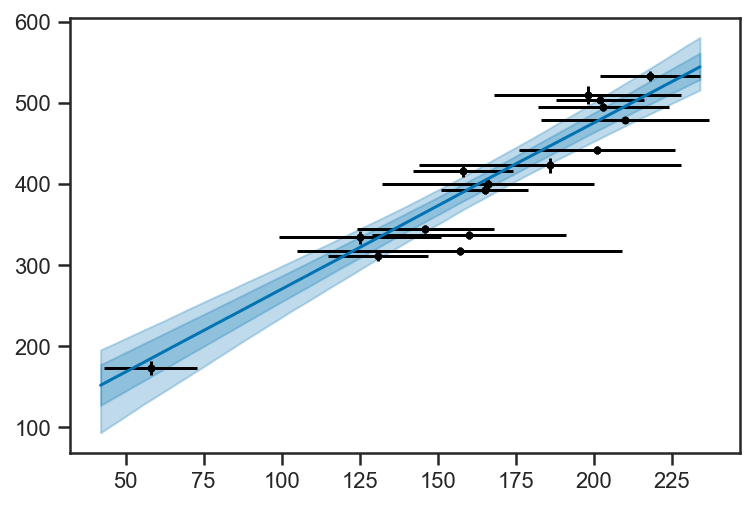

In [41]:
plot_fitted_line(fit_xerr, hogg_data['x'][igood:], hogg_data['y'][igood:], xerr=hogg_data['sigma_x'][igood:], yerr=hogg_data['sigma_y'][igood:])

### Partial Solution: Mixture Model

Here we attack the outliers using a mixture model.  Let's assume here that there is some intrinsic scatter (it will make the derivation of the model easier), so that our y values come in two "cases":

1. "Good" measurements have $y_\mathrm{true} \sim N\left( m x + b, \sigma_\mathrm{int} \right)$
2. "Bad" measurements have $y_\mathrm{true} \sim N\left( \mu_\mathrm{bad}, \sigma_\mathrm{bad} \right)$ (note that in this case there is no connection between the $x$ that is observed and y).

In both cases there remains a connection between $y_\mathrm{true}$ and $y_\mathrm{obs}$, as we have been assuming throughout.

We use Stan's `generated quantities` block to record the ratio between the two mixture probabilities, which is the log of the odds ratio that each observation belongs to one case or the other.

The `linear_mixture.stan` program implements this model in Stan (using the `generated quantities` block to output $y_\mathrm{true}$ for the linear model---case 1---and also the log-ratio between the two terms in the above expression, which is (the log of) the ratio of the probability that each measurement belongs to the good or bad class.

In [22]:
model_mix = pystan.StanModel(file='../stan/linear_mixture.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1496fe71dc46847d37e26a8802adfb0b NOW.
/Users/wfarr/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmps2bw3i2i/stanfit4anon_model_1496fe71dc46847d37e26a8802adfb0b_4267194569854727246.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [25]:
data_mix = {
    'nobs': len(hogg_data['x']),
    'xobs': hogg_data['x'],
    'yobs': hogg_data['y'],
    'sigma_y': hogg_data['sigma_y']
}

In [26]:
fit_mix = model_mix.sampling(data=data_mix)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119686908>,
      dtype=object)

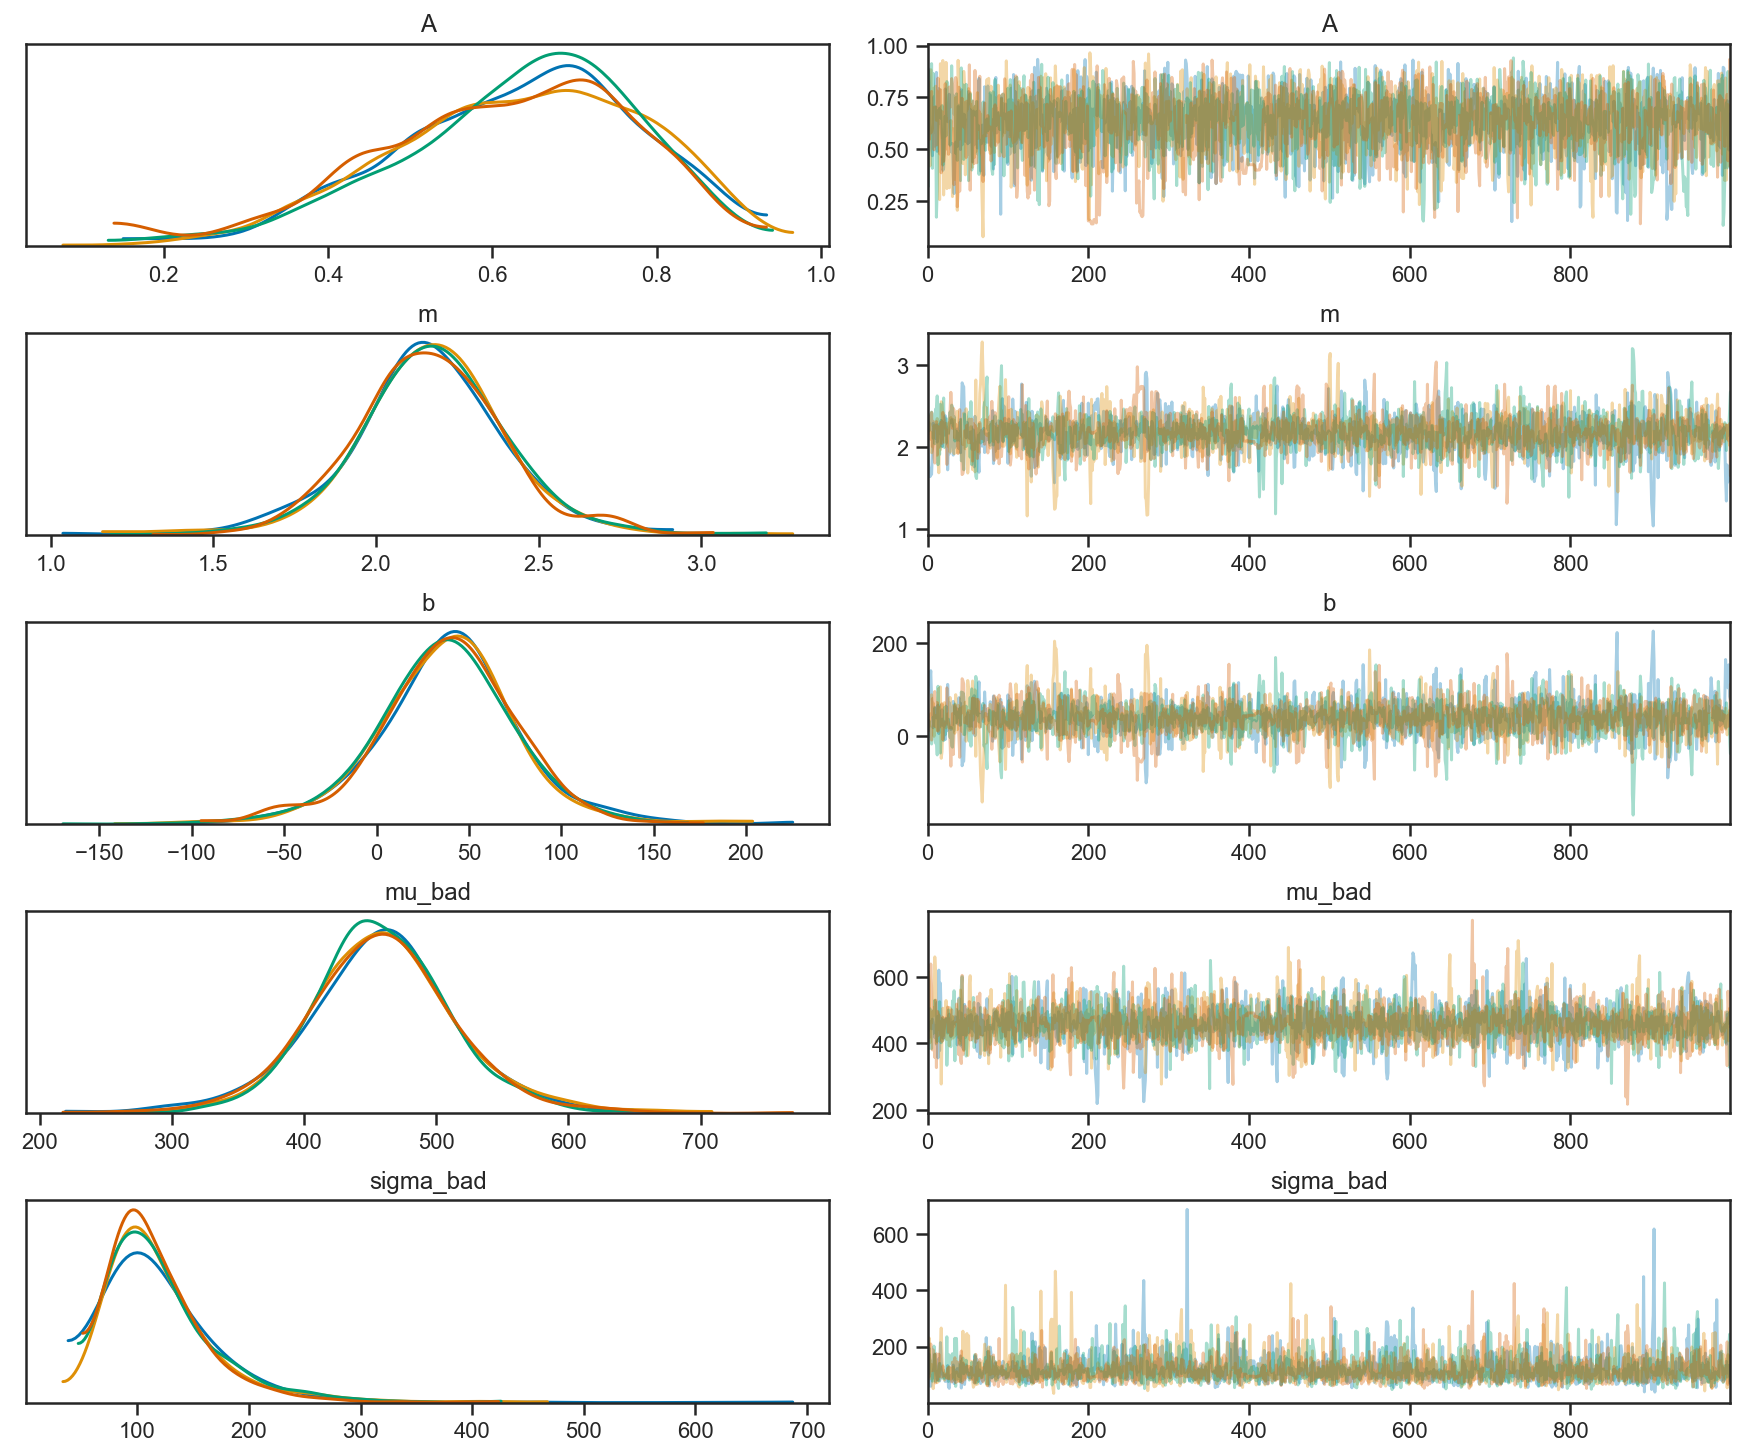

In [27]:
az.plot_trace(fit_mix, var_names=['A', 'm', 'b', 'mu_bad', 'sigma_bad'])

In [28]:
fit_mix = az.convert_to_inference_data(fit_mix)

The overall fraction of "good" data points is $A$:

Text(0, 0.5, '$p(A)$')

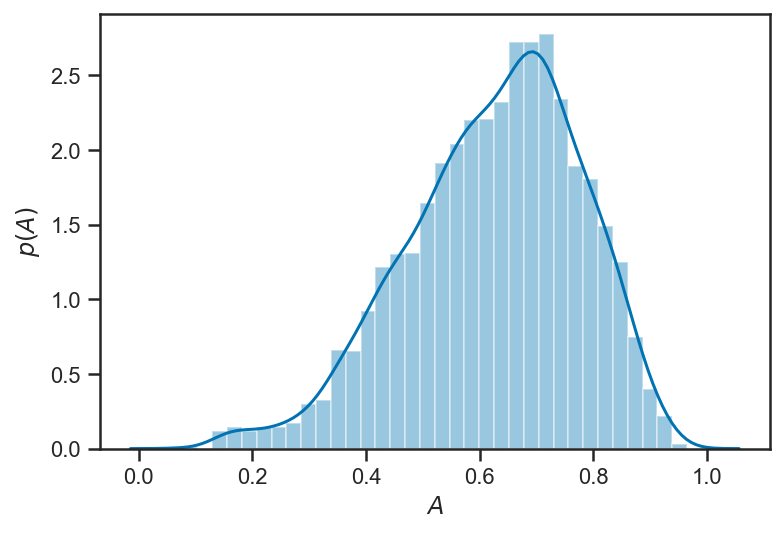

In [30]:
sns.distplot(fit_mix.posterior.A.values.flatten())
xlabel(r'$A$')
ylabel(r'$p(A)$')

Here is our plot of the slope, but now with all points included.  Each point is colored by its membership probability in class 1, given by 
$$
P_\mathrm{mem} = \left \langle \frac{e^r}{1+e^r} \right\rangle
$$
where $r$ is the log odds ratio, and the average is over posterior samples.

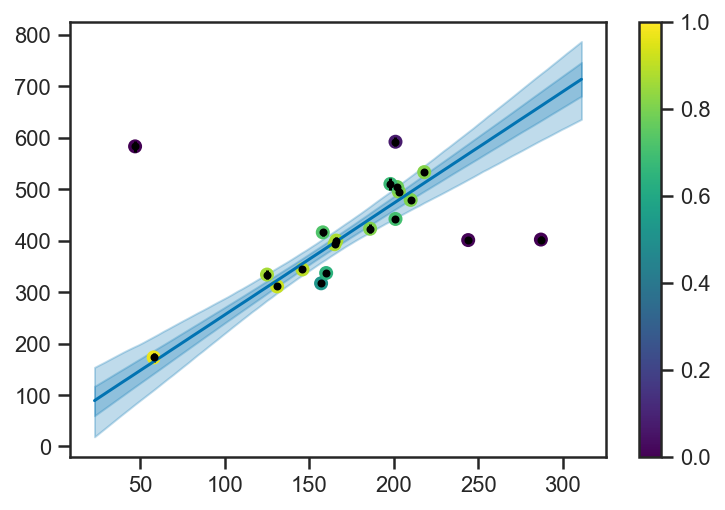

In [37]:
pmem = mean(exp(fit_mix.posterior.log_good_bad_ratio.values - logaddexp(0, fit_mix.posterior.log_good_bad_ratio.values)), axis=(0,1))
plot_fitted_line(fit_mix, hogg_data['x'], hogg_data['y'], yerr=hogg_data['sigma_y'])
scatter(hogg_data['x'], hogg_data['y'], c=pmem, vmin=0, vmax=1, cmap='viridis')
colorbar()

## Problem 2

Cosmology!  Download the Type Ia supernova dataset from [Scolnic, et al. (2017)](https://arxiv.org/abs/1710.00845); you can find it [here](https://archive.stsci.edu/hlsps/ps1cosmo/scolnic/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_lcparam-full.txt).  It gives measurements of the redshift (assumed perfectly measured) and distance modulus (imperfectly measured) for some hundreds of supernova from the PanSTARRS survey.  Recall that the distance modulus is 
$$
\mu = 5 \log_{10} \left( \frac{d_L}{10 \, \mathrm{pc}} \right)
$$
and the luminosity distance (see [Hogg (1999)](https://arxiv.org/abs/astro-ph/9905116)) is given in terms of the cosmological parameters of a flat universe by 
$$
d_L\left( z \mid H_0, \Omega_M, w\right) = \frac{c}{H_0} \int_{0}^z \mathrm{d} z \, \frac{1}{\sqrt{\Omega_M \left( 1 + z \right)^3 + \left( 1 - \Omega_M \right) \left( 1 + z \right)^{3(1+w)}}}.
$$

This is a *non-linear* version of the line fitting problem: we have a perfectly-measured redshift; we use cosmology---rather than a linear relation---to predict the luminosity distance, which predicts the distance modulus.  We then compare to the observed distance modulus (plus uncertainty!) to constrain the cosmology.  You can either learn about how to do integrals like the above in Stan (see [here](https://mc-stan.org/docs/2_20/stan-users-guide/integrate-1d.html); but you will need to install a newer version of Stan and do some fancy coding---this is expert-mode!) or you can use the following rational function approximation to $d_L$ that is good to $z \simeq 1.5$ or so:
$$
d_L = \frac{c}{H_0} \frac{z + z^2\frac{3 - 10 w +3 w^2 + 10 w \Omega_M + 6 w^2 \Omega_M - 9 w^2 \Omega_M^2}{4 \left( 1 - 3 w + 3 w \Omega_M \right)}}{1 + z \frac{1 - 2 w -3 w^2 +2 w \Omega_M + 12 w^2 \Omega_M - 9 w^2 \Omega_M^2}{2 \left( 1 - 3 w + 3 w \Omega_M\right)}}
$$

Recall that there are some limits on variables: $0 \leq \Omega_M < 1$, and $0 < H_0$.  So you will need to declare these in the Stan parameters block:

    real<lower=0,upper=1> Om;
    real<lower=0> H0;
   
It is up to you whether you want to encode the weak energy condition $w > -1$ or not.

### Solution

***Note that there was a bug in the problem as stated; the Scolnic, et al. (2017) data set does not include a distance ladder, so does not determine the absolute magnitude "zero-point" of Ia SNe.  Thus, $H_0$ is not obtainable from this data set.  But, even with the relative distances obtained here we can constrain $\Omega_M$ and $w$.***

I assume you have downloaded the above file and placed it into a directory in the root directory of Day 3 named 'data'.  Let's have a look:

In [43]:
sne_data = pd.read_table('../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_lcparam-full.txt', sep=' ', skiprows=1, usecols=(1,2,3,4,5), names=['zcmb', 'zhel', 'dz', 'mb', 'dmb'])
sne_data

,zcmb,zhel,dz,mb,dmb
0,0.50309,0.50309,0.0,22.93445,0.12605
1,0.49480,0.49480,0.0,22.88020,0.11765
2,0.67767,0.67767,0.0,24.03770,0.20560
3,0.86650,0.86650,0.0,24.34685,0.17385
4,0.79857,0.79857,0.0,24.36050,0.17435
...,...,...,...,...,...
1043,1.30500,1.30500,0.0,25.26420,0.23500
1044,0.93500,0.93500,0.0,24.26660,0.16580
1045,1.01400,1.01400,0.0,24.85445,0.22910
1046,1.31500,1.31500,0.0,25.54235,0.19870


Text(0, 0.5, '$\\mu$')

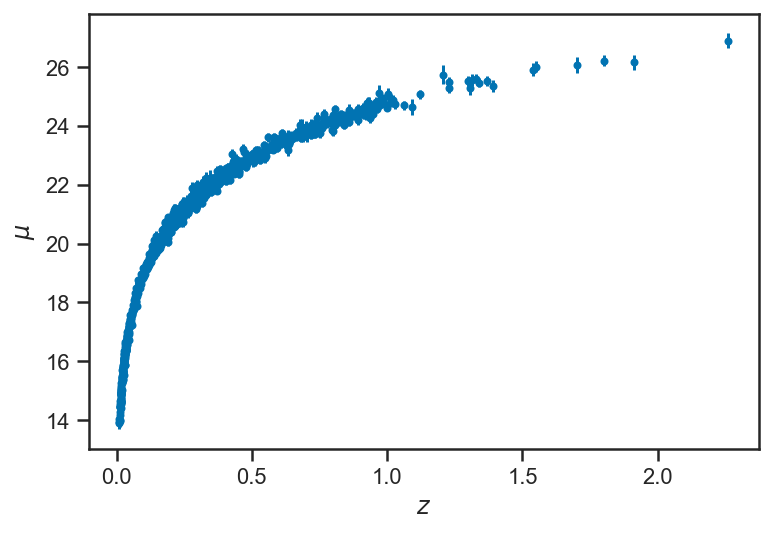

In [53]:
errorbar(sne_data['zcmb'], sne_data['mb'], yerr=sne_data['dmb'], fmt='.')
xlabel(r'$z$')
ylabel(r'$\mu$')

This is very similar to the curve fitting we did in class and Problem 1, but with a modified curve that is not a linear $y = m x + b$.  The stan code is in `sne.stan`; it introduces the use of the `functions` block in stan for user-defined functions.

In [64]:
model_sne = pystan.StanModel(file='../stan/sne.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7e1365028d5d0b04a40c33c315fa1520 NOW.
/Users/wfarr/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpas6x3azh/stanfit4anon_model_7e1365028d5d0b04a40c33c315fa1520_3099753079823090953.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [65]:
dsne = {
    'nobs': len(sne_data['zcmb']),
    'zobs': sne_data['zcmb'],
    'muobs': sne_data['mb'],
    'sigma_mu': sne_data['dmb']
}

In [66]:
fit_sne = model_sne.sampling(data=dsne)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1232a1828>,
      dtype=object)

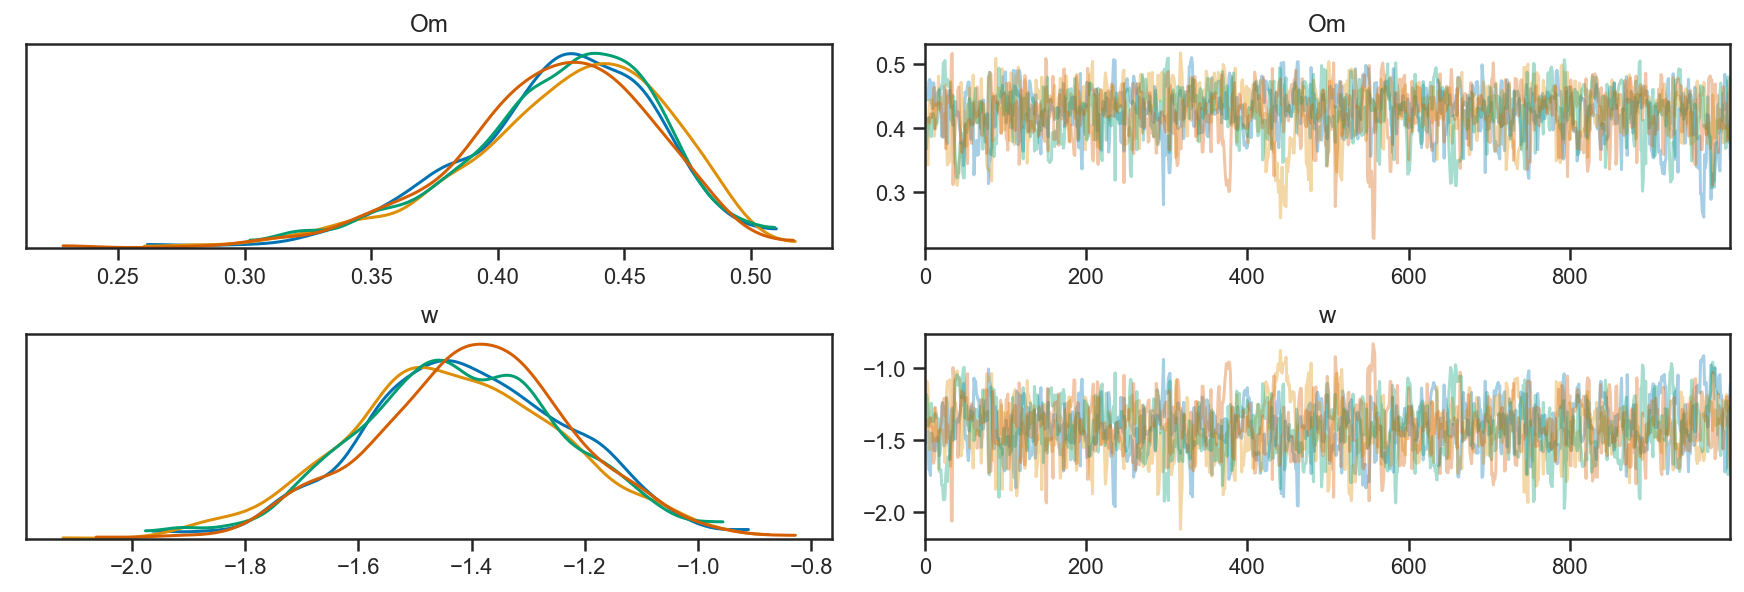

In [67]:
az.plot_trace(fit_sne, var_names=['Om', 'w'])

In [68]:
fit_sne = az.convert_to_inference_data(fit_sne)

Uh oh.  It looks like our approximate formula may have caused some bias.  Let's check whether we get a good fit from the inferred magnitudes:

Text(0, 0.5, '$\\mu$')

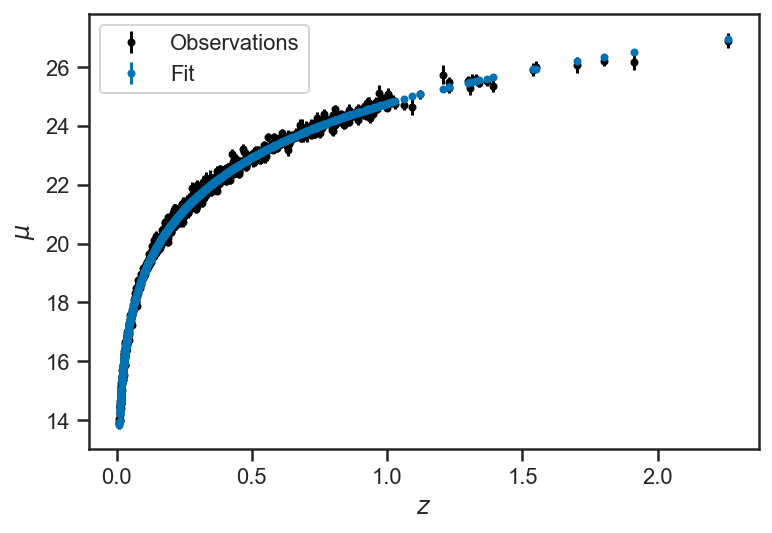

In [69]:
errorbar(sne_data['zcmb'], sne_data['mb'], yerr=sne_data['dmb'], fmt='.', color='k', label='Observations')
errorbar(sne_data['zcmb'], mean(fit_sne.posterior.mu_true.values, axis=(0,1)), yerr=std(fit_sne.posterior.mu_true.values, axis=(0,1)), fmt='.', label='Fit')
legend(loc='best')
xlabel(r'$z$')
ylabel(r'$\mu$')

Or, in residuals:

Text(0, 0.5, '$\\mu - \\mu_\\mathrm{model}$')

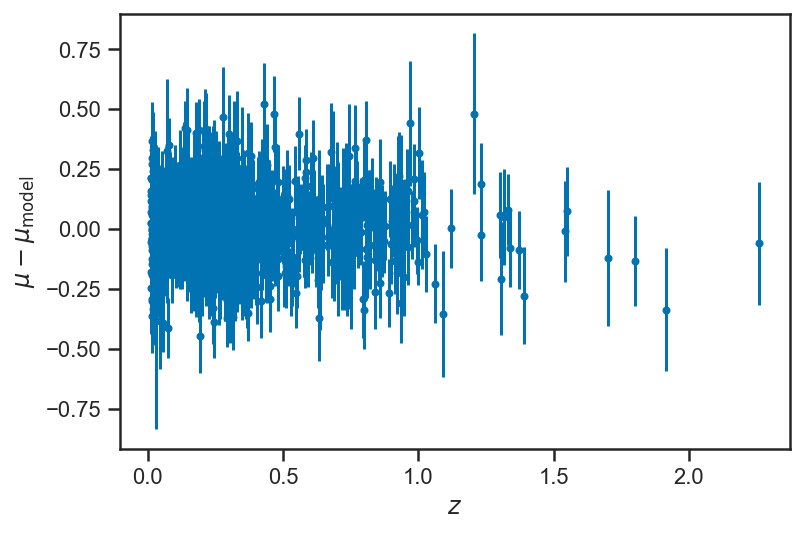

In [72]:
errorbar(sne_data['zcmb'], sne_data['mb']-mean(fit_sne.posterior.mu_true.values, axis=(0,1)), yerr=sne_data['dmb'], fmt='.')
xlabel(r'$z$')
ylabel(r'$\mu - \mu_\mathrm{model}$')

Either way, the fit looks reasonable (though I'm not totally keen on the "wiggle" at low $z$); probably it is just our approximate formula that is causing bias.  Let's fix that by actually integrating the cosmology (FYI: here is how you do integrals in Stan).

In [77]:
model_proper_cosmo = pystan.StanModel(file='../stan/sne_proper_cosmo.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a59801bf37fa0a87a4696ef65f02ba52 NOW.
/Users/wfarr/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp2v43k0hh/stanfit4anon_model_a59801bf37fa0a87a4696ef65f02ba52_8309481676741977919.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Since we are asking the ODE solver to produce the solution at each redshift, and it can only solve *forward*, we need to have the data sorted in $z$.

In [82]:
z = sne_data['zcmb'] + 1e-5*randn(len(sne_data['zcmb'])) # Dither a bit, because some redshifts are repeated.
inds = argsort(z)
data_proper_cosmo = {
    'nobs': len(sne_data['zcmb']),
    'zobs': z[inds],
    'mbobs': sne_data['mb'][inds],
    'sigma_mb': sne_data['dmb'][inds]
}

In [83]:
fit_proper_cosmo = model_proper_cosmo.sampling(data=data_proper_cosmo)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119a1c550>,
      dtype=object)

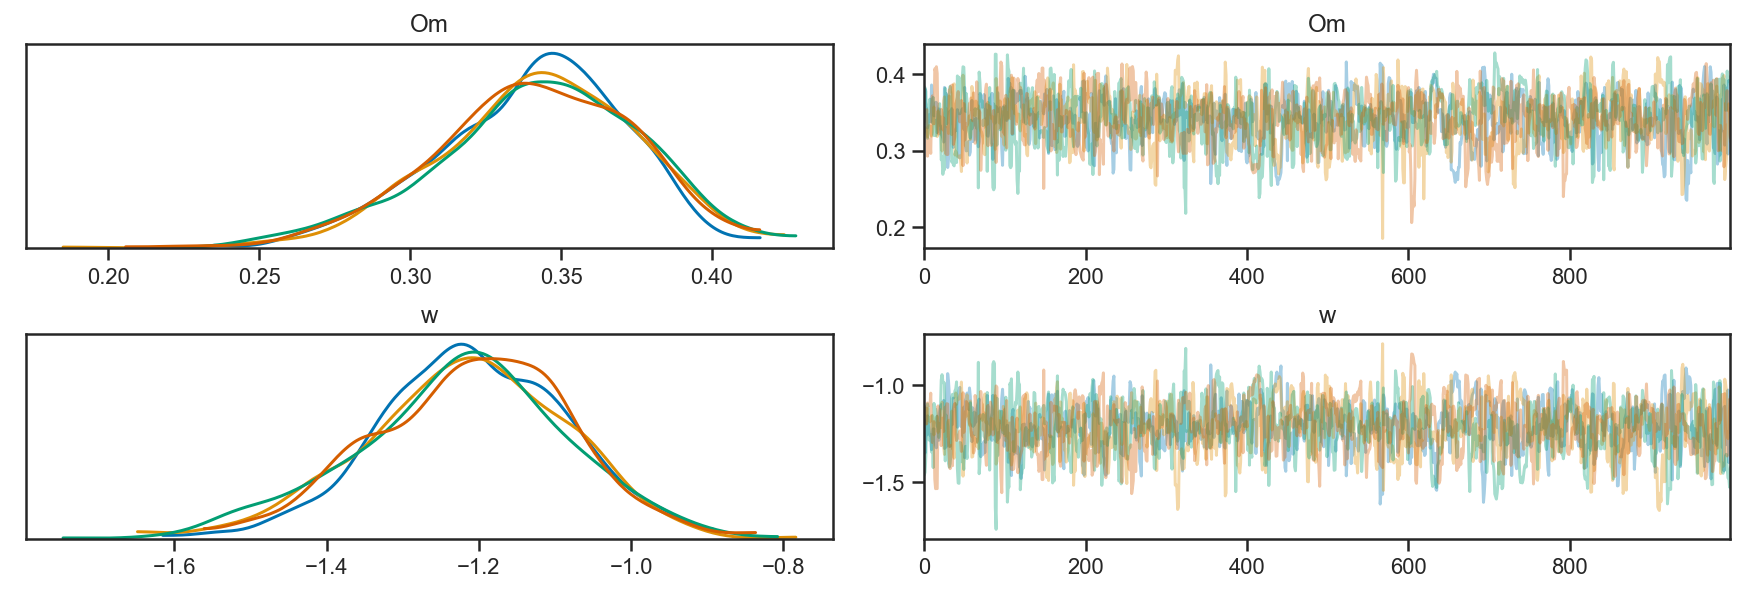

In [84]:
az.plot_trace(fit_proper_cosmo, var_names=['Om', 'w'])

That makes the bias much smaller; probably we could eliminate it entirely if we implemented the per-SNe corrections from Scolnic, et al. (2017) Eq. (3).

## Problem 3

The paper [Pearson, et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015MNRAS.449.3082P/abstract) tried to calibrate a large number of "mass proxies" for galaxy groups based on simulations.  One of the data sets can be found [here](https://github.com/farr/galmassproxy/blob/master/data/obs_cmproxy.csv).  

You can, of course, take each proxy one-by-one in a linear fit similar to those we have been doing.  But, a better approach is to imagine that the true mass and proxies are drawn from a multivariate normal distribution.  Stan has facilities for modelling the mean vector and covariance matrix of this multivariate normal (see [here](https://mc-stan.org/docs/2_20/functions-reference/distributions-over-unbounded-vectors.html) and [here](https://mc-stan.org/docs/2_20/functions-reference/covariance-matrix-distributions.html) or [here](https://mc-stan.org/docs/2_20/functions-reference/correlation-matrix-distributions.html)).  Write down a model that has (log) true mass and some number of proxies drawn from such a MVN, and then constraints the parameters of this MVN using some number of observations with uncertainty.  Fit it to the data in the datasets directory.

Now extend your model to incorporate some number of observations of only the proxy values (i.e. do not include a term in the likelihood for log mass in this subset of observations); the model can still *predict* masses from the MVN using the proxy observations and the observed common distribution.

Comment on the "meaning" of your model; in particular, what are you assuming about the proxies in the "training" set compared to the "observation" set?  